# Ranked Choice Voting
## Currently meant for the specific case of choosing a Flatiron school cohort name

Accepts: a list of ballot-lists, where a ballot-list is a list with first entry the voter's name, and subsequent entries a list of votes that you/they are voting for in order (a votes is a string that appears in the ballot_options list)

This is currently set up to randomly simulate ballots and then run an election

Behaviour - How ranked choice voting works:
 - A ballot consists of a ranking of candidates. e.g. 1st choice = Candidate 3, 2nd choice = Canididate 7, etc.
 - A ballot may rank as few as 1 and as many as all of the candidates on the ballot
 - In each round:
 1. Votes are counted based on the top ranked candidate
 2. If any candidate has the majority of the votes tallied, they win
 3. If all candidates are tied, the result is a tie
 4. Otherwise, candidates tied for the lowest vote total are eliminated.
 
For each ballot, the "top ranked candidate" is specifically the top ranked candidate that has not yet been eliminated. If a ballot is exhausted (all candidates listed are eliminated) then the ballot counts for no candidate

In [1]:
# You may need to install more_itertools, because: why have some when you can have more?
# If you don't have anaconda, you are either (a) sophisticated enough to install software yourself;
#  (b) going to luck into it with pip install; or (c) ...uh good luck, installing software is hard.
#  Try using anaconda? in any of the cases, you should comment this line out or not run it
%conda install more-itertools

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
# You may need to install pandas and seaborn (and dependencies) if
# you don't have a (relatively) standard data science stack set up
#  - See above about how to install software

In [3]:
import itertools, more_itertools, functools
import time, collections
from copy import deepcopy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
ballot_options = [
    '''Chi(yle)^2''',
    '''import alcohol''',
    '''!pip install alcohol''',
    '''Kenny and the Jets''',
    '''Neuman's Own''',
    '''Data Seance''',
    '''Fratiron''',
    '''What_Would_Vishal_Do''',
    '''DeltaSigmaChi(yle)25^2''',
    '''Vishal_and_the_Family''',
    '''PiDelta.Sigma_eries''',
    '''pd.read_csv(alcoh.ol)''',
    '''Kandy's Sweets''',
    '''Gab_is_Great'''
]

In [5]:
# Define a candidate class that track its vote tallies and elimination status
@functools.total_ordering
class Candidate:
    '''
       Class representing a candidate
    '''
    
    def __init__(self, name):
        self.name       = name
        self.eliminated = False
        self.vote_tally = None
        
    def eliminate(self):
        self.eliminated = True
        self.vote_tally = None
        
    def tally_vote(self):
        if not self.vote_tally:
            self.vote_tally = 1
        else:
            self.vote_tally +=1
    
    def reset_tally(self):
        self.vote_tally = None
    
    def reset(self):
        self.eliminated = False
        self.reset_tally()    
        
    def __bool__(self):
        return not self.eliminated
    
    def __eq__(self, other):
        '''
        Sneakily implements two different functions in one:
        (1) If compared to a string, check for equality by name. For lookup purposes
        (2) If compared to a Candidate or int, check for equality by vote total. For sorting purposes
        '''
        if isinstance(other, Candidate):
            if not self.vote_tally:
                return False
            else:
                return self.vote_tally == other.vote_tally
        elif isinstance(other, str):
            return self.name == other
        elif isinstance(other, int):
            return self.vote_tally == other
        else:
            raise TypeError('Candidates can only be tested for equality on '
                            'strings, ints, or other candidates (by vote).')
            
    def __lt__(self, other):
        if not self.vote_tally:
            return True
        if isinstance(other, int):
            return self.vote_tally < other
        elif isinstance(other, Candidate):
            if other.vote_tally is None:
                return False
            else:
                return self.vote_tally < other.vote_tally
        else:
            return TypeError('''Can't compare a candidate to a non int or candidate''')
    
    def __repr__(self):
        return self.name

In [6]:
# Define a ballot class that knows how to look up candidates and vote
class Ballot:
    
    def __init__(self, election, ballot_data):
        self.voter_name         = ballot_data[0]
        
        if not ballot_data[1:]:
            print(f'Warning: ballot for voter {self.voter_name} is blank')

        try:
            self.rankings = [election.lookup_candidate(name) for name in ballot_data[1:]]
        except ValueError as e:
            print(e)
            print(f'Ballot for voter {self.voter_name} is being nullified as invalid')
            self.rankings = []
            
        election.add_ballot(self)
                                    
    def __repr__(self):
        def get_rank_str(i):
                rank = 'Rank' + str(i+1).rjust(3)
                cand = self.rankings[i]
                is_eliminated_char = '-' if cand.eliminated else ' '
                return is_eliminated_char*3 + rank + ': ' + str(cand) + is_eliminated_char*3
        
        head  = [f'Ballot cast by {self.voter_name}']
        ranks = [get_rank_str(i) for i in range(len(self.rankings))]
        
        return '\n'.join(head + ranks)
    
    def __eq__(self, other):
        if isinstance(other, Ballot):
            return self.voter_name == other.voter_name
        else:
            raise TypeError('''Can't compare a ballot to a non-ballot''')
            
    def _top_vote(self):
        remaining = filter(None, self.rankings)
        top_vote  = next(remaining, None)
        return top_vote

    def __bool__(self):
        return bool(self._top_vote())
                    
    def tally_vote(self):
        top_vote = self._top_vote()
        if top_vote:
            top_vote.tally_vote()

In [7]:
# Define an election class that can act like the Sec State: manage ballot access, ballots, and tallying
class Election:
    
    def __init__(self, ballot_options):
        self.ballot_options = ballot_options
        self.candidates = [Candidate(name) for name in ballot_options]
        self.ballots    = []
        self.history    = None
        self.round_num  = 0
        self.completed  = False
        
    def reset(self):
        self.round_num  = 0
        self.completed  = False
        self.history    = None
        for candidate in self.candidates:
            candidate.reset()
            
    def lookup_candidate(self, name):
        try:
            return self.candidates[self.candidates.index(name)]
        except ValueError as e:
            raise ValueError(f'Candidate {name} is not on the ballot in this election') from e
    
    def add_ballot(self, ballot):
        if ballot not in self.ballots:
            self.ballots.append(ballot)
        else:
            raise ValueError(f'''The same voter {ballot.voter_name} is trying to vote twice!''')
    
    def add_ballots(self, ballots):
        for ballot in ballots:
            self.add_ballot(ballot)
            
    def run_round(self):
        # Setup
        self.round_num += 1
        
        # Tally the votes and sort the candidates
        for ballot in self.ballots:
            ballot.tally_vote()
            
        self.candidates.sort(reverse = True)
                        
        # Print the current state of the balloting
        print(f'---------- ROUND {str(self.round_num).rjust(3)} ----------')
        print('Here are the current top-choice totals:')
        for cand in filter(None, self.candidates):
            cand_str = '   ' + cand.name.ljust(50) + ': ' + str(cand.vote_tally).rjust(3)
            print(cand_str)
        print('')
        
        # Put that information in the history (a dataframe)
        round_name = f'round_{self.round_num}'
        names, votes = more_itertools.unzip((cand.name, cand.vote_tally) for cand in self.candidates)
        series = pd.Series(votes, index = names, name = round_name).fillna(0).astype(int)
        if self.history is None:
            self.history = series
            self.history.sort_values(ascending = False, inplace = True)
        else:
            self.history = pd.concat([self.history, series], axis = 'columns', sort = True)
            self._sort_history()
            
        # Count the total number of unexhausted ballots
        total_votes = more_itertools.ilen(filter(None, self.ballots))
            
        # See if there is a winner
        threshold = total_votes // 2 + 1
        leader = self.candidates[0]
        if leader.vote_tally >= threshold:
            print(f'We have a winner! The winner is {leader.name} '
                  f'with {leader.vote_tally} votes out of {total_votes} un-exhausted ballots')
            self.completed = True
            return
            
        # Find candidates with votes
        non_zero_cands  = list(itertools.takewhile(lambda cand : cand > 0, self.candidates))
        
        # Eliminate the eliminees
        eliminate = []
        eliminate_tally = non_zero_cands[-1].vote_tally
        for cand in self.candidates:
            if cand <= eliminate_tally and cand:
                eliminate.append(cand.name)
                cand.eliminate()
                
        # Check for ties (yes, awkwardly, this is possible)
        if len(non_zero_cands) == len(eliminate):
            print('This is awkward... we have a tie')
            self.completed = True
            return
        
        # Otherwise, announce the eliminations
        plural = 's' if len(eliminate) > 1 else ''
        print(f'Eliminating candidates with at most {eliminate_tally} votes')
        print(f'Eliminating candidate{plural}: ' + ', '.join(eliminate) + '\n')
        
        # Cleanup
        for cand in self.candidates:
            cand.reset_tally()
        
        # Finally, for dramatic effect
        print('Please wait while we count the ballots for the next round\n\n\n')
        time.sleep(5)
        
    def run(self):
        while not self.completed:
            self.run_round()
            
    def _sort_history(self):
        self.history.sort_values(self.history.columns.tolist()[::-1], ascending = False, inplace = True)
    
    def get_history(self):
        return self.history
    
    def get_history_chart(self, figsize = (10, 10)):
        fig, ax = plt.subplots(figsize = figsize);
        cmap = sns.light_palette('navy', as_cmap = True);
        sns.heatmap(self.history, annot = True, cmap = cmap, ax = ax);
        return fig

    def get_history_barchart_race(self):
        return 'this is a challenge for Zoe ~ I expect a pull request'

In [8]:
election = Election(ballot_options)

In [9]:
def random_ballot(name, election):
    ballot = deepcopy(election.ballot_options)
    np.random.shuffle(ballot)
    random_len = np.random.randint(1, len(ballot) + 1)
    return Ballot(election, [name] + ballot[:random_len])

In [10]:
votes = [random_ballot(f'test {i+1}', election) for i in range(100)]
votes[0]

Ballot cast by test 1
   Rank  1: import alcohol   
   Rank  2: Chi(yle)^2   
   Rank  3: PiDelta.Sigma_eries   
   Rank  4: Kandy's Sweets   
   Rank  5: Kenny and the Jets   
   Rank  6: Neuman's Own   
   Rank  7: Vishal_and_the_Family   
   Rank  8: Gab_is_Great   
   Rank  9: DeltaSigmaChi(yle)25^2   

In [11]:
election.run()

---------- ROUND   1 ----------
Here are the current top-choice totals:
   Vishal_and_the_Family                             :  15
   import alcohol                                    :  12
   !pip install alcohol                              :   8
   Data Seance                                       :   8
   Fratiron                                          :   8
   PiDelta.Sigma_eries                               :   8
   Neuman's Own                                      :   7
   pd.read_csv(alcoh.ol)                             :   7
   Gab_is_Great                                      :   7
   Chi(yle)^2                                        :   6
   What_Would_Vishal_Do                              :   5
   Kandy's Sweets                                    :   5
   Kenny and the Jets                                :   2
   DeltaSigmaChi(yle)25^2                            :   2

Eliminating candidates with at most 2 votes
Eliminating candidates: Kenny and the Jets, DeltaSigmaChi

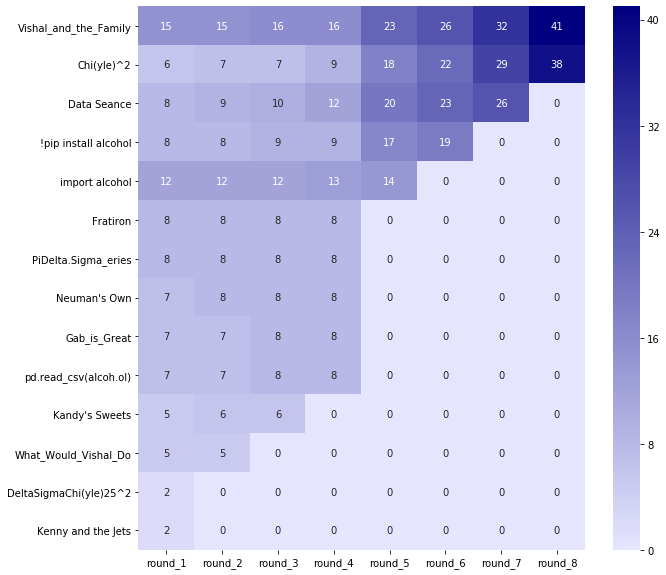

In [12]:
election.get_history_chart();

In [13]:
election.get_history_barchart_race()

'this is a challenge for Zoe ~ I expect a pull request'